In [1]:
!git clone https://github.com/junyuseu/pytorch-cifar-models.git

fatal: destination path 'pytorch-cifar-models' already exists and is not an empty directory.


In [1]:
%cd pytorch-cifar-models/

/content/pytorch-cifar-models


In [2]:
from models import resnet20_cifar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

import time
import numpy as np

In [3]:
class Node(object):
    def __init__(self, dataset, do_shuffle=False):
        self.BATCH_SIZE = 128
        self.LEARNING_RATE = 0.1
        self.MOMENTUM = 0.9
        self.WEIGHT_DECAY = 1e-4 
        self.NUM_CLASSES = 100
        self.dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.BATCH_SIZE, shuffle=do_shuffle, num_workers=2)
        cudnn.benchmark = True

    def create_model(self):
        self.model = resnet20_cifar(num_classes=self.NUM_CLASSES)
        self.model = nn.DataParallel(self.model).cuda()
    def load_model(self, other_node):
        self.model = resnet20_cifar(num_classes=self.NUM_CLASSES)
        self.model.load_state_dict(other_node.model.module.state_dict())
        self.model = nn.DataParallel(self.model).cuda()
    def aggregate_then_load_model(self, other_nodes):
        params = [node.model.module.state_dict() for node in other_nodes]
        self.model = resnet20_cifar(num_classes=self.NUM_CLASSES)
        param_master = dict(self.model.state_dict())
        for name in param_master:
            param_master[name] = 0
            for p in params:
                param_master[name] += p[name] * (1.0 / len(other_nodes))
        self.model.load_state_dict(param_master)
        self.model = nn.DataParallel(self.model).cuda()

    class AverageMeter(object):
        def __init__(self):
            self.reset()
        def reset(self):
            self.val = 0
            self.avg = 0
            self.sum = 0
            self.count = 0
        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
    def accuracy(self, output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

    def train_model(self, which_epoch):
        criterion = nn.CrossEntropyLoss().cuda()
        optimizer = optim.SGD(self.model.parameters(), self.LEARNING_RATE, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)

        batch_time = self.AverageMeter()
        data_time = self.AverageMeter()
        losses = self.AverageMeter()
        top1 = self.AverageMeter()

        self.model.train()

        end = time.time()
        for i, (input, target) in enumerate(self.dataloader):
            # measure data loading time
            data_time.update(time.time() - end)

            input, target = input.cuda(), target.cuda()

            # compute output
            output = self.model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = self.accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        
        return {
            'epoch': which_epoch,
            'batch_time.avg': batch_time.avg,
            'data_time.avg': data_time.avg,
            'losses.avg': losses.avg,
            'top1.avg': top1.avg}

    def evaluate_model(self):
        criterion = nn.CrossEntropyLoss().cuda()
        batch_time = self.AverageMeter()
        losses = self.AverageMeter()
        top1 = self.AverageMeter()

        # switch to evaluate mode
        self.model.eval()

        end = time.time()
        with torch.no_grad():
            for i, (input, target) in enumerate(self.dataloader):
                input, target = input.cuda(), target.cuda()

                # compute output
                output = self.model(input)
                loss = criterion(output, target)

                # measure accuracy and record loss
                prec = self.accuracy(output, target)[0]
                losses.update(loss.item(), input.size(0))
                top1.update(prec.item(), input.size(0))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

        return {
            'batch_time.avg': batch_time.avg,
            'losses.avg': losses.avg,
            'top1.avg': top1.avg}

In [4]:
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

train_dataset = torchvision.datasets.CIFAR100(
  root='./data',
  train=True,
  download=True,
  transform=transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      normalize,
  ]))
train_split_datasest = random_split(train_dataset, [10000, 10000, 10000, 10000, 10000])

test_dataset = torchvision.datasets.CIFAR100(
  root='./data',
  train=False,
  download=True,
  transform=transforms.Compose([
      transforms.ToTensor(),
      normalize,
  ]))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
clients_subsets = [Node(data, do_shuffle=True) for data in train_split_datasest]
server_federator = Node(test_dataset, do_shuffle=False)

client_full = Node(train_dataset, do_shuffle=True)
server_classic = Node(test_dataset, do_shuffle=False)

CLASSIC TRAINING - 50 EPOCHS

~18sec per epoch (in classic and federated)

In [6]:
client_full.create_model()

for epoch in range(1, 50+1):
    print(client_full.train_model(epoch))
    server_classic.load_model(client_full)
    print(server_classic.evaluate_model())

{'epoch': 1, 'batch_time.avg': 0.04504683194562907, 'data_time.avg': 0.014085736725946216, 'losses.avg': 3.965691941986084, 'top1.avg': 8.392}
{'batch_time.avg': 0.02519203439543519, 'losses.avg': 3.6688918243408204, 'top1.avg': 13.51}
{'epoch': 2, 'batch_time.avg': 0.04313638021269113, 'data_time.avg': 0.013835560635227681, 'losses.avg': 3.4069320793151854, 'top1.avg': 16.956}
{'batch_time.avg': 0.04265422760685788, 'losses.avg': 3.376181998825073, 'top1.avg': 19.21}
{'epoch': 3, 'batch_time.avg': 0.04386738743013738, 'data_time.avg': 0.014204725280137318, 'losses.avg': 2.946572094116211, 'top1.avg': 25.35}
{'batch_time.avg': 0.02533946459806418, 'losses.avg': 3.20298840675354, 'top1.avg': 24.23}
{'epoch': 4, 'batch_time.avg': 0.04395209066093425, 'data_time.avg': 0.013958247421342699, 'losses.avg': 2.596434449996948, 'top1.avg': 32.466}
{'batch_time.avg': 0.024864495555056803, 'losses.avg': 3.091620096206665, 'top1.avg': 26.49}
{'epoch': 5, 'batch_time.avg': 0.043037550528640944, 'da

FEDERATED TRAINING - 50 EPOCHS

IN EACH EPOCH: EACH CLIENT TRAINS #1 EPOCH, so collectively all samples are used once

In [7]:
server_federator.create_model()

for epoch in range(1, 50+1):
    for client_idx in range(len(clients_subsets)):
        client = clients_subsets[client_idx]
        client.load_model(server_federator)
        print('client training #', client_idx, client.train_model(epoch))
    server_federator.aggregate_then_load_model(clients_subsets)
    print('server evaluation:', server_federator.evaluate_model())

client training # 0 {'epoch': 1, 'batch_time.avg': 0.045098413394976264, 'data_time.avg': 0.015087894246548036, 'losses.avg': 4.407847500610352, 'top1.avg': 3.21}
client training # 1 {'epoch': 1, 'batch_time.avg': 0.043727980384343786, 'data_time.avg': 0.014109557188009913, 'losses.avg': 4.422984429168701, 'top1.avg': 3.11}
client training # 2 {'epoch': 1, 'batch_time.avg': 0.0432941098756428, 'data_time.avg': 0.014947981774052488, 'losses.avg': 4.428100756072998, 'top1.avg': 2.92}
client training # 3 {'epoch': 1, 'batch_time.avg': 0.04370737075805664, 'data_time.avg': 0.014210625539852095, 'losses.avg': 4.429288793182373, 'top1.avg': 3.09}
client training # 4 {'epoch': 1, 'batch_time.avg': 0.04381493073475512, 'data_time.avg': 0.014723104766652555, 'losses.avg': 4.4212605628967285, 'top1.avg': 3.28}
server evaluation: {'batch_time.avg': 0.025038034101075763, 'losses.avg': 4.557403146362304, 'top1.avg': 1.42}
client training # 0 {'epoch': 2, 'batch_time.avg': 0.04317911968955511, 'data

In [8]:
import matplotlib.pyplot as plt

In [10]:
classic_train_loss = [3.965691941986084, 3.4069320793151854, 2.946572094116211, 2.596434449996948, 2.3487498406219482, 2.16729426071167, 2.0290422665786743, 1.92869426612854, 1.8368714684295655, 1.765304737625122, 1.6939938619613648, 1.6557500473022462, 1.603310743484497, 1.5727674898910522, 1.530354594154358, 1.5025509560394288, 1.4725685466766358, 1.4448754391479492, 1.4293597588348388, 1.4009588390350343, 1.3794029256439209, 1.3553950616455077, 1.3390285612106323, 1.3178037009429933, 1.3055015800094605, 1.2878509717941284, 1.2785267517471313, 1.2664795195007323, 1.2438034731292724, 1.2425956858062743, 1.2296533066558837, 1.2195974557495117, 1.2112799390411377, 1.2090723837280273, 1.19190546169281, 1.191831263961792, 1.1754102536392212, 1.1739903101348876, 1.1695545966720582, 1.1556492107391358, 1.1425098427200318, 1.1397763904571534, 1.1337738972473144, 1.1364482787322998, 1.127581592578888, 1.116870287284851, 1.1134231979751588, 1.0995022151184082, 1.1039014613723754, 1.0957720928192138]
classic_train_top1acc = [8.392, 16.956, 25.35, 32.466, 37.45, 41.394, 44.69, 47.1, 49.208, 50.832, 52.84, 53.51, 54.84, 55.288, 56.766, 57.326, 58.216, 58.864, 59.05, 59.79, 60.45, 61.004, 61.464, 62.232, 62.372, 62.876, 63.072, 63.16, 64.102, 63.824, 64.276, 64.558, 64.776, 64.96, 65.262, 65.154, 65.64, 65.794, 65.984, 66.162, 66.416, 66.676, 66.8, 66.762, 66.98, 67.06, 67.458, 67.94, 67.36, 67.878]
classic_test_top1acc = [13.51, 19.21, 24.23, 26.49, 31.06, 39.13, 42.15, 40.96, 44.28, 45.64, 49.41, 46.68, 46.95, 50.03, 51.08, 49.02, 48.83, 51.64, 50.82, 53.63, 54.41, 53.27, 54.05, 49.94, 56.41, 53.67, 55.17, 55.51, 55.32, 55.19, 53.08, 52.67, 56.17, 55.43, 58.23, 56.35, 56.22, 53.46, 57.88, 57.92, 56.46, 55.72, 57.65, 53.53, 55.99, 57.04, 57.86, 56.21, 55.75, 58.21]
classic_test_loss = [3.6688918243408204, 3.376181998825073, 3.20298840675354, 3.091620096206665, 2.8207536922454834, 2.39261364364624, 2.164037648010254, 2.308090034866333, 2.0775985471725464, 2.055665376663208, 1.8748367027282715, 2.0164350200653076, 2.0315410840988157, 1.8866001306533813, 1.798959330177307, 1.9383202211380004, 1.9893050521850586, 1.8283601097106934, 1.8963709201812744, 1.7485911703109742, 1.6732444269180298, 1.73476007938385, 1.722839471244812, 1.9449490215301513, 1.6673974636077882, 1.7588103134155273, 1.6698077518463135, 1.713263515663147, 1.691243706703186, 1.7058834276199342, 1.8404252334594726, 1.8527012060165404, 1.678942085647583, 1.6767854955673218, 1.5470750368118287, 1.601269814491272, 1.6671858100891113, 1.7997516109466554, 1.5811682159423828, 1.566693622970581, 1.6721143342971803, 1.753659036064148, 1.6010358058929444, 1.8569971284866333, 1.6682708547592162, 1.657852016067505, 1.6116361072540284, 1.6756641611099243, 1.719181840324402, 1.588701534461975]

In [11]:
federated_server_loss = [4.557403146362304, 4.062288917541504, 3.7418298835754396, 3.6004598236083982, 3.5396496883392334, 3.355599948883057, 3.2908765647888183, 3.1479787322998045, 3.093480573654175, 2.9184111698150637, 2.794077802658081, 2.7455411209106444, 2.7284630893707273, 2.6416296768188476, 2.55040421295166, 2.5003405559539793, 2.4287274951934816, 2.336195864868164, 2.2511629173278807, 2.236570462036133, 2.170874870300293, 2.1159288234710694, 2.168661459159851, 1.9944832918167115, 1.9911052484512328, 1.9596341960906982, 1.889730217552185, 1.9537804170608521, 1.853412843322754, 1.8609682794570923, 1.90373665599823, 1.8751253917694093, 1.8153478353500365, 1.8029599252700805, 1.7265079860687256, 1.8236020191192628, 1.7172248302459716, 1.6953871829986573, 1.756590888595581, 1.6421273275375365, 1.6679722190856934, 1.7719057455062865, 1.624136993598938, 1.672854548072815, 1.620696273612976, 1.5951135509490966, 1.6520264442443848, 1.5669400547027588, 1.6077312423706054, 1.6224830926895142]
federated_server_top1acc = [1.42, 6.25, 11.95, 13.71, 14.54, 18.43, 19.23, 22.24, 23.21, 26.82, 28.52, 29.79, 29.96, 31.83, 33.66, 34.68, 36.4, 38.24, 40.45, 40.24, 41.55, 43.14, 42.83, 45.64, 46.15, 46.6, 48.15, 47.72, 49.33, 49.46, 49.2, 49.33, 50.16, 51.58, 52.91, 50.78, 52.76, 53.77, 53.17, 54.28, 54.14, 52.81, 55.5, 54.99, 55.45, 55.45, 55.25, 56.49, 55.54, 55.98]
federated_client0_top1acc = [3.21, 5.75, 8.22, 10.39, 11.92, 13.91, 15.75, 17.94, 19.85, 22.41, 24.36, 26.2, 27.82, 28.56, 31.07, 31.84, 33.67, 34.49, 35.44, 37.1, 39.02, 39.35, 40.71, 41.79, 42.35, 43.03, 43.71, 44.8, 45.93, 46.34, 46.91, 47.05, 48.11, 48.51, 49.31, 49.42, 50.63, 50.92, 51.01, 51.61, 52.8, 52.77, 52.63, 53.2, 53.51, 54.47, 54.73, 54.22, 55.38, 55.48]
federated_client1_top1acc = [3.11, 5.39, 8.45, 10.77, 12.79, 13.94, 16.08, 17.73, 19.51, 21.87, 23.48, 25.36, 27.35, 28.66, 29.79, 31.46, 32.48, 33.76, 35.11, 36.53, 38.0, 38.82, 39.96, 40.8, 41.55, 43.07, 43.0, 43.71, 45.04, 45.93, 46.36, 47.54, 47.71, 48.82, 49.11, 49.49, 50.13, 50.74, 51.61, 51.17, 51.12, 52.05, 52.8, 53.37, 53.6, 52.87, 54.02, 54.34, 55.11, 54.58]
federated_client2_top1acc = [2.92, 5.49, 8.26, 10.46, 11.85, 14.44, 16.24, 18.92, 19.33, 21.35, 23.48, 25.53, 27.77, 28.11, 30.4, 31.09, 34.1, 34.18, 35.94, 36.83, 38.01, 39.02, 40.69, 40.49, 42.36, 43.29, 43.84, 44.46, 46.29, 46.52, 46.61, 47.59, 47.99, 48.4, 48.79, 49.11, 50.46, 50.47, 51.26, 51.72, 52.09, 51.76, 52.72, 53.14, 53.55, 53.4, 54.8, 54.95, 54.77, 55.5]
federated_client3_top1acc = [3.09, 5.73, 8.4, 10.5, 12.08, 14.36, 16.15, 18.03, 19.32, 21.72, 23.4, 25.24, 28.04, 28.59, 29.86, 31.59, 32.97, 34.4, 34.85, 36.64, 38.07, 39.27, 40.33, 40.57, 42.77, 43.5, 43.41, 44.51, 45.65, 46.14, 46.84, 46.92, 48.12, 48.77, 48.66, 49.93, 50.28, 51.35, 50.75, 51.0, 52.81, 53.3, 52.55, 52.85, 52.94, 53.77, 53.86, 55.73, 54.11, 55.2]
federated_client4_top1acc = [3.28, 5.51, 8.57, 10.45, 12.47, 14.44, 16.09, 17.19, 20.02, 22.32, 23.85, 25.18, 27.11, 28.52, 29.85, 31.03, 32.67, 34.26, 35.97, 36.6, 37.54, 39.22, 40.13, 40.92, 42.15, 43.4, 44.61, 44.6, 45.6, 45.7, 46.76, 47.04, 48.23, 48.99, 48.52, 49.91, 50.45, 50.92, 50.91, 52.51, 51.77, 52.66, 52.31, 53.9, 53.56, 53.65, 54.62, 54.57, 54.81, 55.09]
federated_client0_loss = [4.407847500610352, 4.116439108276367, 3.925584033203125, 3.774181991195679, 3.6832201091766357, 3.5591122631073, 3.4606125213623047, 3.3695457180023194, 3.249206244277954, 3.1373328399658202, 3.0113996101379397, 2.9229970985412597, 2.8398975048065185, 2.780256539916992, 2.6921510509490965, 2.626154280471802, 2.5432223350524903, 2.484857448196411, 2.422271564483643, 2.3528479888916016, 2.302616736602783, 2.254775700759888, 2.2257184894561766, 2.1652953998565674, 2.132478108215332, 2.090799076080322, 2.0602773754119874, 2.017351776504517, 1.9834498844146728, 1.9604337284088136, 1.9122768230438232, 1.9227847423553466, 1.8757518939971924, 1.8637209228515625, 1.8228935306549072, 1.8081607236862183, 1.7793579071044923, 1.7450612155914307, 1.7629970520019531, 1.7252957313537598, 1.6858352062225341, 1.6999292625427247, 1.6914959999084473, 1.6669098482131959, 1.6419897453308105, 1.605352163505554, 1.611377869796753, 1.623155976486206, 1.580526634979248, 1.569373037147522]
federated_client1_loss = [4.422984429168701, 4.128496341705322, 3.9240119552612303, 3.7683285625457765, 3.660948139190674, 3.555022289276123, 3.4534689506530762, 3.3572503757476806, 3.2255001331329347, 3.1347441398620606, 3.0379908588409426, 2.93019924621582, 2.8404961502075197, 2.762369633102417, 2.6920809776306154, 2.623928518676758, 2.566281800079346, 2.4905203140258787, 2.452429754638672, 2.3830942485809326, 2.32209621925354, 2.279068814086914, 2.2193626766204835, 2.1703437267303465, 2.156663611984253, 2.092675592803955, 2.0826248329162595, 2.0416160720825194, 1.9957283412933349, 1.963039912033081, 1.9453422889709473, 1.9015975536346434, 1.8844622200012207, 1.8501046314239502, 1.8337199802398683, 1.8260803518295288, 1.8014913080215453, 1.7590402284622193, 1.7410168886184691, 1.7376744689941406, 1.7389548946380615, 1.710555415725708, 1.6605249504089354, 1.6449090175628662, 1.651254335975647, 1.65834691696167, 1.623114909362793, 1.6102438898086548, 1.595780790901184, 1.586328324508667]
federated_client2_loss = [4.428100756072998, 4.110511348342896, 3.9311595920562743, 3.7822038928985595, 3.686766473388672, 3.566260464477539, 3.4538189140319826, 3.354681678009033, 3.2504584297180177, 3.143404008483887, 3.025186083602905, 2.922286738204956, 2.8457175144195554, 2.794349817276001, 2.7142336921691896, 2.6258812713623048, 2.5493826873779297, 2.49186480178833, 2.433674857711792, 2.3809295875549314, 2.3326475646972655, 2.27995640335083, 2.2003314037323, 2.1846173259735107, 2.1300655055999758, 2.100759445953369, 2.05586544342041, 2.0268266609191894, 1.98408815574646, 1.9482145698547364, 1.9375166110992432, 1.9077537284851074, 1.881256335258484, 1.8598685241699218, 1.8460666748046874, 1.8161452674865723, 1.780458539199829, 1.7585568717956543, 1.7437194549560546, 1.7318702407836915, 1.710630948638916, 1.6957531969070434, 1.6963372798919678, 1.6573995456695556, 1.6508452201843262, 1.6458102542877198, 1.6186348793029786, 1.6087420921325684, 1.5929042846679689, 1.5701763084411622]
federated_client3_loss = [4.429288793182373, 4.110515972137451, 3.9180585903167726, 3.777564803314209, 3.6606703010559083, 3.5575389656066894, 3.4572953048706054, 3.341253527069092, 3.2527948211669924, 3.1419260822296144, 3.047703873062134, 2.9499533866882324, 2.8548585536956788, 2.7754371265411377, 2.6953342777252196, 2.632933799743652, 2.573047640991211, 2.4796869899749754, 2.4542896423339844, 2.3899899826049804, 2.322412755584717, 2.277047245025635, 2.216686156654358, 2.1939885292053223, 2.1284488372802732, 2.0872392959594728, 2.0744355058670045, 2.040911156463623, 1.9904366199493408, 1.9783686923980712, 1.933719388961792, 1.9355789169311524, 1.8678852035522462, 1.8700324516296387, 1.8441682222366333, 1.7993553047180175, 1.780317476272583, 1.772082805633545, 1.761185583114624, 1.7440697296142578, 1.7024992593765258, 1.6748601476669311, 1.6949036237716675, 1.665553713607788, 1.6587353050231934, 1.647745993423462, 1.622781560897827, 1.5861259132385255, 1.617779930305481, 1.579968085861206]
federated_client4_loss = [4.4212605628967285, 4.110550259780884, 3.926158253479004, 3.781734935760498, 3.663674095916748, 3.573868796157837, 3.452546244430542, 3.354461925125122, 3.2419551525115966, 3.1270653739929197, 3.015052562713623, 2.930168157958984, 2.8476267333984375, 2.7713607173919677, 2.709157344818115, 2.6354186340332033, 2.558819813156128, 2.4965449111938476, 2.411401148605347, 2.3836647621154787, 2.307888009262085, 2.2742625869750976, 2.2224624938964843, 2.1782028480529787, 2.1250966705322267, 2.0763523727416993, 2.0520550983428953, 2.0168560428619386, 1.985872504425049, 1.973132564163208, 1.919214695739746, 1.8991825368881226, 1.8818944231033325, 1.859511926651001, 1.8344117475509643, 1.798161280441284, 1.7817437088012695, 1.7647455055236816, 1.7701272956848144, 1.6987094110488892, 1.7093826652526856, 1.6867508026123046, 1.6777477642059326, 1.6495963478088378, 1.6359936191558837, 1.6314133354187013, 1.6117481811523438, 1.5954208848953246, 1.5932267948150636, 1.5846611303329468]

In [13]:
len(classic_train_loss)

50

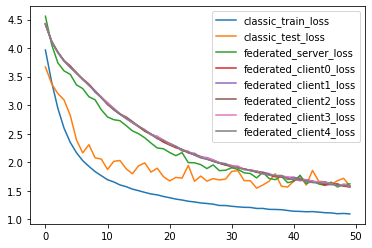

In [15]:
plt.plot(classic_train_loss, label='classic_train_loss')
plt.plot(classic_test_loss, label='classic_test_loss')
plt.plot(federated_server_loss, label='federated_server_loss')
plt.plot(federated_client0_loss, label='federated_client0_loss')
plt.plot(federated_client1_loss, label='federated_client1_loss')
plt.plot(federated_client2_loss, label='federated_client2_loss')
plt.plot(federated_client3_loss, label='federated_client3_loss')
plt.plot(federated_client4_loss, label='federated_client4_loss')
plt.legend()
plt.show()

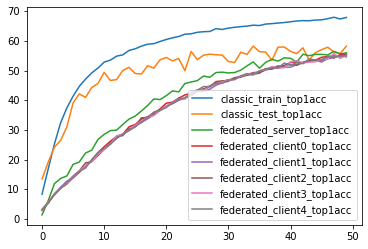

In [16]:
plt.plot(classic_train_top1acc, label='classic_train_top1acc')
plt.plot(classic_test_top1acc, label='classic_test_top1acc')
plt.plot(federated_server_top1acc, label='federated_server_top1acc')
plt.plot(federated_client0_top1acc, label='federated_client0_top1acc')
plt.plot(federated_client1_top1acc, label='federated_client1_top1acc')
plt.plot(federated_client2_top1acc, label='federated_client2_top1acc')
plt.plot(federated_client3_top1acc, label='federated_client3_top1acc')
plt.plot(federated_client4_top1acc, label='federated_client4_top1acc')
plt.legend()
plt.show()